| 模型             | 理解                         | 用途                                            |
| ---------------- | ----------------------------- | ----------------------------------------------- |
| **Merton 模型**    | 把公司**违约看作资产价值低于债务**的一次性事件     | **结构性建模（Structural Model）**，基于公司资产负债表           |
| **Intensity 模型** | 把违约看作**概率随机发生的事件流**，不关注具体资产价值 | **减少结构假设，直接建“违约率路径”**，灵活适用于市场校准与 stress testing |


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

## Step 1：Simulating Client Data

In [2]:
def simulate_pd_data(n_samples=1000, beta=[0.5, -0.3], random_state=42):  # x1 = 客户杠杆率 =0.5, x2 = 客户收入增长率
    
    #确保每次运行都生成相同的数据,否则每次跑出来的 λ 和违约率都不一样
    np.random.seed(random_state) 

    #模拟两列特征变量 X1 和 X2（可以扩展更多特征）
    X = np.random.normal(0, 1, size=(n_samples, len(beta)))
    
    #根据特征变量计算 λ（Poisson 强度）: λ = exp(Xβ)
    lambda_ = np.exp(X @ beta)

    #设定观察期 T，比如看他未来1.5~3年是否违约
    T = np.random.uniform(1.5, 3.0, size=n_samples) 

    #从指数分布中采样违约时间 τ
    U = np.random.uniform(0, 1, size=n_samples)
    tau = -np.log(U) / lambda_  # 反函数采样法

    #判断是否违约
    event = (tau <= T).astype(int)

    #整合成 DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'T': T,
        'tau': tau,
        'lambda': lambda_,
        'event': event
    })

    return df

In [3]:
df = simulate_pd_data()
print(df.head())

         X1        X2         T       tau    lambda  event
0  0.496714 -0.138264  2.110660  0.895025  1.336209      1
1  0.647689  1.523030  1.599015  0.655409  0.875408      1
2 -0.234153 -0.234137  2.023231  0.228871  0.954244      1
3  1.579213  0.767435  1.666497  1.135524  1.749580      1
4 -0.469474  0.542560  2.712353  0.808820  0.671994      1


## Step 2: Define Probability Default(PD) Model

In [4]:
class PoissonPDModel:
    def __init__(self, X, T, event):
        self.X = X #特征矩阵（n × p）
        self.T = T #观察期向量（n × 1）
        self.event = event #是否违约（n × 1）

    #计算 λ = exp(Xβ)
    def _intensity(self, beta):
        return np.exp(self.X @ beta)
    
    #负对数似然函数，用于最小化
    def _neg_log_likelihood(self, beta):
        lambda_ = self._intensity(beta)   
        ll = self.event * np.log(lambda_) - lambda_ * self.T   
        return -np.sum(ll)
    
    #拟合参数 β
    def fit(self):
        init_beta = np.zeros(self.X.shape[1])  # 初始值设为全0
        result = minimize(self._neg_log_likelihood, init_beta)
        self.beta_hat = result.x
        return self.beta_hat
    
    #预测 PD 值 = 1 - exp(-λ * T)
    def predict_pd(self, X_new, T_new):
        lambda_pred = np.exp(X_new @ self.beta_hat)
        pd_pred = 1 - np.exp(-lambda_pred * T_new)
        return pd_pred

## Step 3: Fit the model 

In [5]:
#准备输入变量
X = df[['X1', 'X2']].values
T = df['T'].values
event = df['event'].values

#拟合模型
model = PoissonPDModel(X, T, event)
beta_hat = model.fit()
print("Estimated Beta:", beta_hat)

# 输出预测的PD
df['PD_pred'] = model.predict_pd(X, T)
df

Estimated Beta: [ 0.02569331 -0.05420103]


,X1,X2,T,tau,lambda,event,PD_pred
0,0.496714,-0.138264,2.110660,0.895025,1.336209,1,0.883963
1,0.647689,1.523030,1.599015,0.655409,0.875408,1,0.776205
2,-0.234153,-0.234137,2.023231,0.228871,0.954244,1,0.869552
3,1.579213,0.767435,1.666497,1.135524,1.749580,1,0.810771
4,-0.469474,0.542560,2.712353,0.808820,0.671994,1,0.925888
...,...,...,...,...,...,...,...
995,0.800410,0.754291,2.013968,1.059957,1.189957,1,0.861025
996,1.188913,0.708304,2.796988,0.624852,1.465162,1,0.937659
997,0.351448,1.070150,1.732388,0.241019,0.864745,1,0.807872
998,-0.026521,-0.881875,1.624105,3.327838,1.285698,0,0.817765


| 方法              | 用途                          |
| -----  | --------------------------- |
| ROC曲线     | 看模型排序能力（AUC 越高越好）           |
| KS曲线     | 看模型能否区分违约 vs 非违约人群（KS 越大越好） |
| 分箱分析   | 看预测概率与实际违约率是否一致             |


## Step 4: Define the ROC Curve, KS Curve, and Bin Chart

In [6]:
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)  #fpr = False Postive Rate, tpr = True Postive Rate 
    auc = roc_auc_score(y_true, y_score)   # AUC = Area Under Curve, 目的是随机抽一个违约客户和一个未违约客户，模型能正确排序的概率

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_ks(y_true, y_score, n_bins=10):
    df = pd.DataFrame({'score': y_score, 'label': y_true})
    df = df.sort_values(by='score', ascending=False)
    df['bucket'] = pd.qcut(df['score'], q=n_bins, duplicates='drop')

    grouped = df.groupby('bucket', as_index=False, observed=True).agg({
        'label': ['count', 'sum']
    })
    grouped.columns = ['bucket', 'total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    grouped['cum_bad'] = grouped['bad'].cumsum()
    grouped['cum_good'] = grouped['good'].cumsum()

    total_bad = grouped['bad'].sum()
    total_good = grouped['good'].sum()

    grouped['cum_bad_pct'] = grouped['cum_bad'] / total_bad
    grouped['cum_good_pct'] = grouped['cum_good'] / total_good
    grouped['ks'] = np.abs(grouped['cum_bad_pct'] - grouped['cum_good_pct'])

    ks_max = grouped['ks'].max()

    plt.figure()
    plt.plot(grouped['cum_bad_pct'], label='Cumulative Bad Rate')
    plt.plot(grouped['cum_good_pct'], label='Cumulative Good Rate')
    plt.title(f'KS Curve (Max KS = {ks_max:.2f})')
    plt.xlabel('Score Bucket (descending)')
    plt.ylabel('Cumulative Percentage')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_bin_chart(y_true, y_score, n_bins=10):
    df = pd.DataFrame({'score': y_score, 'label': y_true})
    df['bucket'] = pd.qcut(df['score'], q=n_bins, duplicates='drop')
    grouped = df.groupby('bucket', as_index=False,observed=True).agg({
        'label': ['count', 'mean']
    })
    grouped.columns = ['bucket', 'count', 'actual_default_rate']

    plt.figure()
    plt.bar(range(len(grouped)), grouped['actual_default_rate'])
    plt.xticks(range(len(grouped)), [str(b) for b in grouped['bucket']], rotation=45)
    plt.title('Actual Default Rate by Score Bin')
    plt.ylabel('Default Rate')
    plt.xlabel('Score Bin')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 5: Model Evaluation

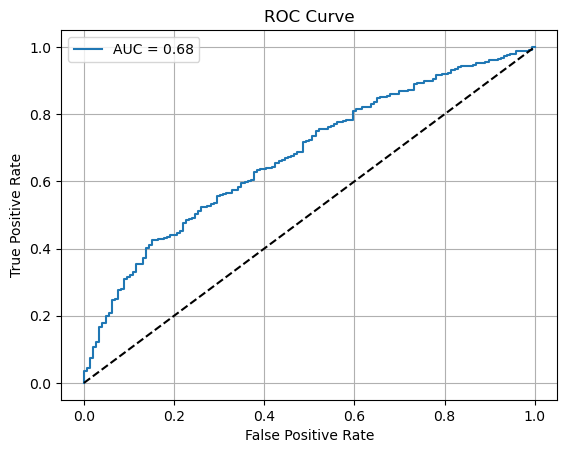

In [7]:
#传入真实值和预测违约概率
y_true = df['event']
y_score = df['PD_pred']

# ROC
plot_roc(y_true, y_score)

#### **Conclusion**:
- 模型有一定区分力,能大致判断谁风险高
- 模型意义：任意抽两个客户（一个违约一个未违约），模型预测违约概率更高的那个真的是违约的概率
- 但排序准确性还有提升空间, AUC < 0.70 仍算中等偏弱
- 可能原因：
    1) 自变量 X1, X2 和真实风险的相关性不强
    2) 特征没有做标准化或衍生 
    3) Poisson模型结构仍较为简单

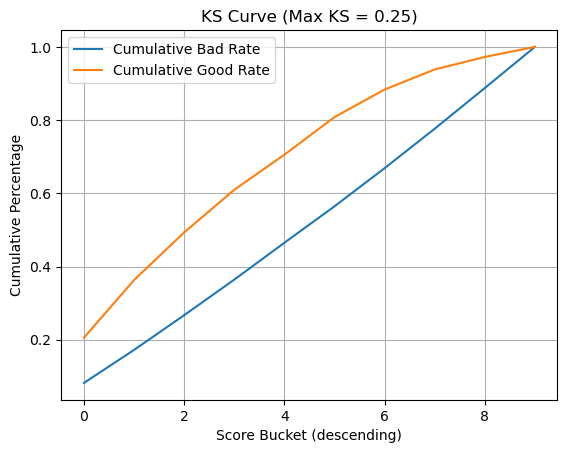

In [8]:
# KS Scorce
plot_ks(y_true, y_score)

#### **Conclusion**:
- KS Scorce的意思是模型对违约客户和非违约客户的识别差异能力 KS < 0.2 代表弱， KS > 0.5 代表强
- **总结**：
  | 结论                | 解读                                  |
| ----------------- | ----------------------------------- |
| 模型可以一定程度上区分违约客户   | 但 KS 仅为 0.25，说明分辨力不强                |
| 风险较高客户与正常客户分数交错   | 有可能 λ (intensity) 受特征 X1/X2 表达不清晰导致 |
| 模型在高风险分数段并未显著集中违约 | 若用于贷款定价、授信限额，仍需加上更多变量进行增强建模         |

- **How to improve**:
  | 方向   | 建议                 |
| ---- | ---------------------------------------------------------------- |
| 特征工程 | 增加与违约强相关的特征（如负债比、信用评分、还款历史等）                                     |
| 模型比较 | 引入逻辑回归、XGBoost、随机森林等模型做横向对比                                      |
| 分段建模 | 按贷款类型、客户类型进行分层建模（分组后再建模）                                         |
| 阈值调整 | 选择最优 cut-off 以最小化成本函数，例如 maximize KS 或 minimize FPR at fixed TPR |


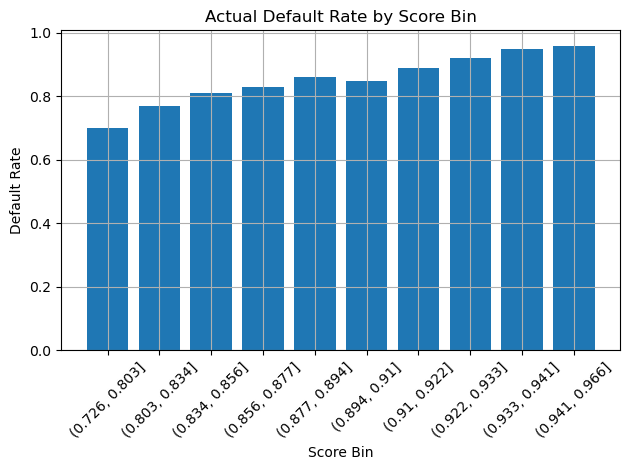

In [9]:
# Bin Chart
plot_bin_chart(y_true, y_score)

#### 图形解释

| 元素                | 含义                                                |
| ----------------- | ------------------------------------------------- |
| 横轴 Score Bin    | 你将模型输出的违约概率 PD_pred 分成了 10 个分数区间（每个 bin 大致等量数据） |
| 纵轴 Default Rate | 每个区间内的 **实际违约率**，即真实标签event=1的占比              |
| 柱子的高度             | 越高代表该分数段的实际违约率越高                                  |

#### Result: 
**一个好的PD模型应当满足:**
1) 得分越高（PD越大），违约率越高 → 实现严格递增的关系。
2) 如果柱子从左到右基本单调上升，则说明：模型的预测结果和实际违约概率趋势一致，说明模型是“可解释的”、“有区分力的”。
3) 整体从左到右是上升的，但略有波动, 说明整体上具备可解释性，但可能仍有进一步改进空间

# Step 7: Stress Testing

#### 1) Obtain RBA Cash Rate

In [10]:
url = "https://www.rba.gov.au/statistics/cash-rate/"

# 抓取网页中的所有表格
tables = pd.read_html(url)

# 查看页面中抓取到的所有表格数量
print(f"Get {len(tables)} tables")

# 假设第一个就是目标表格
rba_df = tables[0]

共抓到 1 张表


In [11]:
rba_df

,Effective Date,Change% points,Cash rate target %,Related Documents
0,9 Jul 2025,0.00,3.85,Statement Minutes
1,21 May 2025,-0.25,3.85,Statement Minutes
2,2 Apr 2025,0.00,4.10,Statement Minutes
3,19 Feb 2025,-0.25,4.10,Statement Minutes
4,11 Dec 2024,0.00,4.35,Statement Minutes
...,...,...,...,...
391,23 Jan 1990,-0.50 to -1.00,17.00 to 17.50,Statement
392,Legend:,Legend:,Legend:,Legend:
393,Cash rate decreased,Cash rate decreased,Cash rate decreased,Cash rate decreased
394,Cash rate increased,Cash rate increased,Cash rate increased,Cash rate increased


In [12]:
# Step 1: 去除包含 "Legend" 的行
rba_df = rba_df[~rba_df['Cash rate target %'].astype(str).str.contains('Legend|to')].copy()

# Step 2: 只保留有效列并重命名
rba_df = rba_df[['Effective Date', 'Cash rate target %']].rename(columns={
    'Effective Date': 'date',
    'Cash rate target %': 'cash_rate'
})

rba_df

,date,cash_rate
0,9 Jul 2025,3.85
1,21 May 2025,3.85
2,2 Apr 2025,4.10
3,19 Feb 2025,4.10
4,11 Dec 2024,4.35
...,...,...
383,5 Sep 1990,14.00
384,2 Aug 1990,14.00
393,Cash rate decreased,Cash rate decreased
394,Cash rate increased,Cash rate increased


In [13]:
rba_df = rba_df.drop([393,394,395])
rba_df

,date,cash_rate
0,9 Jul 2025,3.85
1,21 May 2025,3.85
2,2 Apr 2025,4.10
3,19 Feb 2025,4.10
4,11 Dec 2024,4.35
...,...,...
380,18 Dec 1990,12.00
381,7 Nov 1990,13.00
382,15 Oct 1990,13.00
383,5 Sep 1990,14.00


In [14]:
# Step 3: 类型转换
rba_df['date'] = pd.to_datetime(rba_df['date'], dayfirst=True, errors='coerce')  # 自动识别日/月/年格式
rba_df['cash_rate'] = pd.to_numeric(rba_df['cash_rate'], errors='coerce')
rba_df

,date,cash_rate
0,2025-07-09,3.85
1,2025-05-21,3.85
2,2025-04-02,4.10
3,2025-02-19,4.10
4,2024-12-11,4.35
...,...,...
380,1990-12-18,12.00
381,1990-11-07,13.00
382,1990-10-15,13.00
383,1990-09-05,14.00


In [15]:
rba_df = rba_df.dropna()
rba_df.isnull().sum()

date         0
cash_rate    0
dtype: int64

In [17]:
# 从 RBA 数据中提取 cash_rate 值
rba_rates = rba_df['cash_rate'].dropna().values

# 从历史利率中随机采样，生成与模拟样本数相同的 X3
df['X3'] = np.random.choice(rba_rates, size=len(df), replace=True)
df

,X1,X2,T,tau,lambda,event,PD_pred,X3
0,0.496714,-0.138264,2.110660,0.895025,1.336209,1,0.883963,2.00
1,0.647689,1.523030,1.599015,0.655409,0.875408,1,0.776205,6.50
2,-0.234153,-0.234137,2.023231,0.228871,0.954244,1,0.869552,7.50
3,1.579213,0.767435,1.666497,1.135524,1.749580,1,0.810771,0.75
4,-0.469474,0.542560,2.712353,0.808820,0.671994,1,0.925888,1.50
...,...,...,...,...,...,...,...,...
995,0.800410,0.754291,2.013968,1.059957,1.189957,1,0.861025,12.00
996,1.188913,0.708304,2.796988,0.624852,1.465162,1,0.937659,12.00
997,0.351448,1.070150,1.732388,0.241019,0.864745,1,0.807872,0.85
998,-0.026521,-0.881875,1.624105,3.327838,1.285698,0,0.817765,5.00


#### 2): 使用新的 X1, X2, X3 特征重新拟合 Poisson 强度模型

In [19]:
# 准备建模特征和目标变量
X = df[['X1', 'X2', 'X3']]
T = df['T']
event = df['event']

#拟合模型
model = PoissonPDModel(X, T, event)
beta_hat = model.fit()
print("Estimated Beta:", beta_hat)

# 输出预测的PD
df['PD_pred'] = model.predict_pd(X, T)
df

Estimated Beta: [ 0.08255005 -0.054513   -0.18530588]


,X1,X2,T,tau,lambda,event,PD_pred,X3
0,0.496714,-0.138264,2.110660,0.895025,1.336209,1,0.783352,2.00
1,0.647689,1.523030,1.599015,0.655409,0.875408,1,0.372174,6.50
2,-0.234153,-0.234137,2.023231,0.228871,0.954244,1,0.393919,7.50
3,1.579213,0.767435,1.666497,1.135524,1.749580,1,0.794951,0.75
4,-0.469474,0.542560,2.712353,0.808820,0.671994,1,0.853168,1.50
...,...,...,...,...,...,...,...,...
995,0.800410,0.754291,2.013968,1.059957,1.189957,1,0.200238,12.00
996,1.188913,0.708304,2.796988,0.624852,1.465162,1,0.274744,12.00
997,0.351448,1.070150,1.732388,0.241019,0.864745,1,0.762397,0.85
998,-0.026521,-0.881875,1.624105,3.327838,1.285698,0,0.489935,5.00


#### 3): Visualize interactive plot

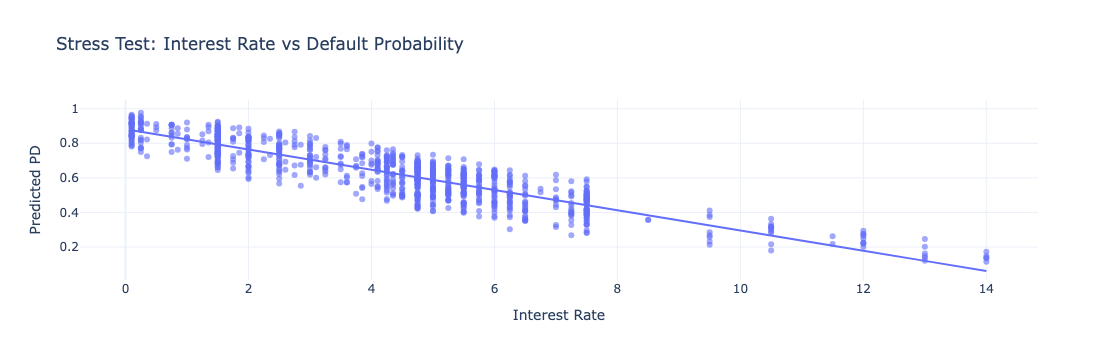

In [22]:
import plotly.express as px

fig = px.scatter(
    df, 
    x='X3', 
    y='PD_pred', 
    title='Stress Test: Interest Rate vs Default Probability',
    labels={'X3': 'Interest Rate', 'PD_pred': 'Predicted PD'},
    opacity=0.6,
    trendline='ols'
)

fig.update_layout(
    template='plotly_white',
    hovermode='closest'
)

fig.show()